# Solving the combined classification and regression task

Problem

The calorimeter has a multiple showers where the energy is distributed through multiple blocks. The shower centers can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside of that. Energy from the shower that falls outside of the calorimeter however, is lost. 

In the example, there are 2 showers. 

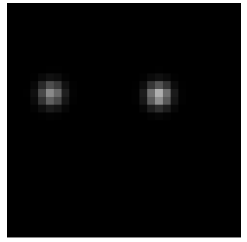

Each shower has three values: shower amplitude, x-coordinate of shower center, y-coordinate of shower center.
So in case of 3 showers we have (amp1, X1, Y1, amp2, X2, Y2, amp3, X3, Y3). For events with fewer than 3 showers, the parameters are set to –1. So for example, for a 1 shower event the labels would be (amp1, X1, Y1, -1, -1, -1, -1, -1, -1).

The showers here are all “clean” with no noise or backgrounds. 

The data comes as PNG files (8-bit greyscale) for each of the events that are stored in the relevant directory such as "train_images". For this set, there is an CSV file named "train_images.csv". The first column is just the PNG file name and the next 9 columns represent the amplitude, x, y of the three showers (in that order) in the same units as are used for the labels. 
For events with fewer than 3 showers, the amplitudes for the missing showers should be set to a value < 0. Any showers with an amplitude less than 0 will be considered to mean “no shower”. 


The solution to this problem will consist of a single CSV file with 9 columns containing the parameters (amp, X, Y) for each of 3 showers in the event for the events in the judge.csv or judge_images.csv file. Each row in the output should correspond to the events in the judge data set, in the same order of the events there. 

Our input is represented as a set of images, that's why CNN was chosen as a model. We need to get the predictions for the number of showers (from 0 to 3), so we face with the classification task. At the same time we have to predict continuous values, so it's a regression task as well. The approach to solving this task is to use functional method and create a few "branches" from the last Dense layer in order to get several outputs.

Firstly let's import all necessary python libraries

In [4]:
import os
from os import listdir
from os.path import isfile, join
import glob
import time
import pandas as pd
import numpy as np
from numpy import unravel_index
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt

The helping function for the counting the number of showers.

In [5]:
def check_output(row):
    count_minus1 = 0
    for r in row:
        if r==-1:
            count_minus1 += 1
    if count_minus1 == 3:
        return 2
    elif count_minus1 == 6:
        return 1
    else:
        return 3       

Get input from csv-file and create Pandas DataFrames with train, test and judge data

In [6]:
source = "https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem4/"

# train dataset
df_train = pd.read_csv(
    os.path.join(source,"train_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_train.columns[0]: 'filename', 
           df_train.columns[1]: 'amp1', df_train.columns[2]: 'X1', df_train.columns[3]: 'Y1',
           df_train.columns[4]: 'amp2', df_train.columns[5]: 'X2', df_train.columns[6]: 'Y2',
           df_train.columns[7]: 'amp3', df_train.columns[8]: 'X3', df_train.columns[9]: 'Y3'}
df_train = df_train.rename(columns=mapping)

df_train['filename'] = df_train['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_train['filename'] = df_train['filename'].str.replace(r'.png', '',regex=True)+'.png'
df_train['number of showers'] = df_train.apply(check_output, axis=1).astype(str)

# test dataset
df_test = pd.read_csv(
    os.path.join(source,"test_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_test.columns[0]: 'filename', 
           df_test.columns[1]: 'amp1', df_test.columns[2]: 'X1', df_test.columns[3]: 'Y1',
           df_test.columns[4]: 'amp2', df_test.columns[5]: 'X2', df_test.columns[6]: 'Y2',
           df_test.columns[7]: 'amp3', df_test.columns[8]: 'X3', df_test.columns[9]: 'Y3'}
df_test = df_test.rename(columns=mapping)

df_test['filename'] = df_test['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_test['filename'] = df_test['filename'].str.replace(r'.png', '',regex=True)+'.png'
df_test['number of showers'] = df_test.apply(check_output, axis=1).astype(str)

# judge dataset
df_judge = pd.read_csv(
    os.path.join(source,"judge_images.csv"), 
    na_values=['NA', '?'], header=None)

mapping = {df_judge.columns[0]: 'filename'}
df_judge = df_judge.rename(columns=mapping)

df_judge['filename'] = df_judge['filename'].str.replace(r'^j\w*([^.])', '',regex=True)
df_judge['filename'] = df_judge['filename'].str.replace(r'.png', '',regex=True)+'.png'

df_judge
print(f"Training size: {len(df_train)}")
print(f"Test size: {len(df_test)}")
print(f"Judge size: {len(df_judge)}")
df_train


Training size: 10000
Test size: 2000
Judge size: 2000


filename    amp1        X1        Y1    amp2        X2        Y2  \
0     event000000.png  4.4593 -620.8455 -225.5054  5.6767  298.8510 -214.1872   
1     event000001.png  4.9037 -660.6001 -624.6932  4.8617  333.7888 -435.3781   
2     event000002.png  3.7578   -4.5944  -27.0048  1.9341  477.7302  433.5288   
3     event000003.png  6.6876 -503.7320  -73.0594  1.1281  166.2398  287.7479   
4     event000004.png  4.9604 -283.3962  254.8166 -1.0000   -1.0000   -1.0000   
...               ...     ...       ...       ...     ...       ...       ...   
9995  event009995.png  2.3794  626.8511 -328.0300 -1.0000   -1.0000   -1.0000   
9996  event009996.png  0.7685  180.3918 -279.4919  7.5918 -895.1000  -89.8132   
9997  event009997.png  1.4535  117.8182  121.1105 -1.0000   -1.0000   -1.0000   
9998  event009998.png  4.1975 -846.5471  192.4005  5.9448 -372.5540  504.9717   
9999  event009999.png  1.6290  -74.5726 -833.3144 -1.0000   -1.0000   -1.0000   

        amp3       X3        Y3 number of showers  
0    -1.0000  -1.0000   -1.0000                 2  
1     0.8389  56.6473  759.6743                 3  
2    -1.0000  -1.0000   -1.0000                 2  
3     1.6650  55.5156 -379.8192                 3  
4    -1.0000  -1.0000   -1.0000                 1  
...      ...      ...       ...               ...  
9995 -1.0000  -1.0000   -1.0000                 1  
9996 -1.0000  -1.0000   -1.0000                 2  
9997 -1.0000  -1.0000   -1.0000                 1  
9998 -1.0000  -1.0000   -1.0000                 2  
9999 -1.0000  -1.0000   -1.0000                 1  

[10000 rows x 11 columns]

Let's build a data generator. We will not divide the train dataset to the train and validation datasets, we'll just use test data for validation purpose

In [7]:
datagen=ImageDataGenerator()

The function flow_from_dataframe loads the labels from a Pandas dataframe connected to our train_images.csv file. 

We have to specify paths to the directories which contains all the images, because our x_col doesn't contain absolute_paths pointing to each image files instead of just filenames.

Parameter x_col points to the name of the column which contains the filenames of the images, y_col — points to the name of the column which contains the label.

We have to set class_mode equals to “categorical”, because we have the data in the column as categorical values (str datatype).

Batch_size will be 32 for the training and validation datasets and 1 for the test dataset.

Shuffle is set to True for train and validation generators and False for test generator, because we need to yield the images in “order”, to predict the outputs and match them with their unique filenames.

In [8]:
path_train = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem4/train_images'
path_test = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem4/test_images'
path_judge = 'C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem4/judge_images'

train_generator=datagen.flow_from_dataframe(
                dataframe=df_train,
                directory=path_train,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

valid_generator=datagen.flow_from_dataframe(
                dataframe=df_test,
                directory=path_test,
                x_col="filename",
                y_col='number of showers',
                batch_size=32,
                seed=42,
                #shuffle=True,
                class_mode="categorical",
                target_size=(30,30),
                color_mode='grayscale')

test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(
                dataframe=df_judge,
                directory=path_judge,
                x_col="filename",
                y_col='number of showers',
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(30,30),
                color_mode='grayscale')

Found 10000 validated image filenames belonging to 3 classes.
Found 2000 validated image filenames belonging to 3 classes.
Found 2000 validated image filenames.


Now let's build the model.

In [9]:
class_count = len(train_generator.class_indices)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
          input_shape=(30,30,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])

Let's fit the model.

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)


Epoch 1/10
312/312 [==============================] - 10s 32ms/step - loss: 1.1036 - accuracy: 0.4671 - val_loss: 0.8672 - val_accuracy: 0.6930
Epoch 2/10
312/312 [==============================] - 10s 33ms/step - loss: 0.7874 - accuracy: 0.6436 - val_loss: 0.6050 - val_accuracy: 0.7739
Epoch 3/10
312/312 [==============================] - 11s 35ms/step - loss: 0.6099 - accuracy: 0.7286 - val_loss: 0.4865 - val_accuracy: 0.8181
Epoch 4/10
312/312 [==============================] - 11s 36ms/step - loss: 0.4968 - accuracy: 0.7823 - val_loss: 0.4658 - val_accuracy: 0.8486
Epoch 5/10
312/312 [==============================] - 11s 35ms/step - loss: 0.4416 - accuracy: 0.8077 - val_loss: 0.4627 - val_accuracy: 0.8679
Epoch 6/10
312/312 [==============================] - 11s 36ms/step - loss: 0.3955 - accuracy: 0.8343 - val_loss: 0.3307 - val_accuracy: 0.8689
Epoch 7/10
312/312 [==============================] - 11s 36ms/step - loss: 0.3619 - accuracy: 0.8508 - val_loss: 0.2582 - val_accuracy

To see the dynamics of accuracy we can build the plot

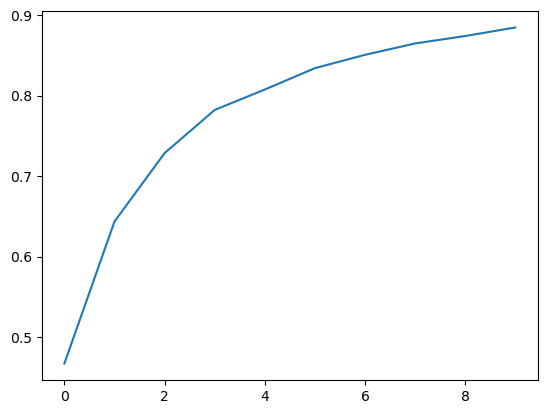

In [11]:
plt.plot(history.history['accuracy'])
plt.show()

Evaluate the model

In [12]:
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_TEST)

[0.23524026572704315, 0.9289178848266602]

Let's predict the output for the judge dataset. We need to reset the test_generator before whenever you call the predict_generator. This is important, if we don't want to get outputs in a weird order.

In [13]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

2000/2000 [==============================] - 2s 1ms/step


Now we have to map the predicted labels with their unique ids such as filenames to find out what we predicted for which image.

In [14]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

We got the results of the first step, we found the predicted number of showers.

In [15]:
filenames = test_generator.filenames
results_1_step = pd.DataFrame({"Filename":filenames,
                               "Predictions":predictions})
results_1_step

Filename Predictions
0     event000000.png           3
1     event000001.png           3
2     event000002.png           2
3     event000003.png           1
4     event000004.png           2
...               ...         ...
1995  event001995.png           1
1996  event001996.png           1
1997  event001997.png           1
1998  event001998.png           1
1999  event001999.png           1

[2000 rows x 2 columns]

The next step is to find amplitude, coordinate X and Y for the each shower. We have 3 cases: 1 shower, 2 showers, 3 showers.
For the next step we will use the model from the first task that predict amplitude, coordinate X and Y for the one shower. And instead of pictures we will take a CSV-file as an input.

Let's load the model from the first task

In [16]:
model1 = tf.keras.models.load_model("find_amp_X_Y_model.keras")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The function that takes the first 900 columns is also the same as in the first task

In [17]:
#function that retrieves the input variable columns from the CSV and returns a pandas dataframe containing the columns
def retrieve_X_df(df, verbose = True):
  """
  :param df: Required, the dataframe containing the input and output variables. The first 900 values for each observation are assumed the input variables.
  :param verbose: Optional, default==True, prints the shape of the dataframe after retrieving the input columns.

  :return: dataframe containing the input data. 
  """
  df = df.iloc[:,0:900]
  if verbose:
    print("df shape: ", df.shape)
  return df

Let's read the judge dataset and use the model to predict the amplitude, coordinate X and Y for the one shower on the base of it 

In [19]:
#Read judge csv 
df_judge = pd.read_csv(os.path.join(source,"judge.csv"), na_values=['NA', '?'], header=None)

#Get inputs
df_judge_X = retrieve_X_df(df_judge)

#Predict the outputs 
preds_judge = model1.predict(df_judge_X)

#Put the predictions into the dataframe
output_judge = pd.DataFrame({'number_of_showers':predictions,'amplitude':preds_judge[:,0].flatten(),
                             'X':preds_judge[:,1].flatten(),'Y':preds_judge[:,2].flatten()})
output_judge.tail(9)

df shape:  (2000, 900)


number_of_showers  amplitude           X           Y
1991                 2   4.385166 -671.331848 -274.552551
1992                 2   3.834257  198.275391 -411.768768
1993                 3   3.811370 -125.175560 -208.557755
1994                 3   2.121415   36.127254  432.431763
1995                 1   3.144086 -248.158249 -763.782104
1996                 1   3.807225 -416.699982   62.176167
1997                 1   2.652193    6.870988  106.814491
1998                 1   3.026883    8.875751  127.465576
1999                 1   2.039744 -254.952072   37.669891

It would be great to see our whole dataframe. Pandas has an options system that lets you customize some aspects of its behavior, display-related options being those the user is most likely to adjust. For instance, we can change the number of columns to be displayed using set_option function

In [20]:
pd.set_option('max_columns', None)
df_judge.tail(10)

0    1    2    3    4    5    6    7       8       9       10      11   \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

         12      13      14   15   16   17   18   19   20   21   22   23   \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      24   25   26   27   28   29   30   31   32   33   34   35   36      37   \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

         38      39      40      41      42      43      44      45   46   \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1991  0.0003  0.0003  0.0002  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1994  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1995  0.0022  0.0215  0.0814  0.1223  0.0732  0.0174  0.0016  0.0001  0.0   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1999  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   

      47   48   49   50   51   52   53   54   55   56   57   58   59   60   \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Next we add the values we got on the previous step to the new dataframe

In [24]:
df_judge['number_of_showers'] = predictions
df_judge['amplitude'] = preds_judge[:,0].flatten()
df_judge['X'] = preds_judge[:,1].flatten()
df_judge['Y'] = preds_judge[:,2].flatten()
df_judge.tail(12)

0    1    2    3    4    5    6    7       8       9      10      11  \
1988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1988  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1989  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40      41      42      43      44      45   46  \
1988  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1989  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1991  0.0003  0.0003  0.0002  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1994  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1995  0.0022  0.0215  0.0814  0.1223  0.0732  0.0174  0.0016  0.0001  0.0   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.

It is interesting to know what is the mean value of the shower's amplitude

In [27]:
df_judge['amplitude'].describe()

count    2000.000000
mean        3.789744
std         1.149266
min        -1.750280
25%         3.126354
50%         3.644679
75%         4.342755
max         9.935984
Name: amplitude, dtype: float64

Our next task is to build the function that finds and masks the one of the showers. 

For the testing purpose, let's make a copy of the judge dataframe

In [28]:
df_judge1 = df_judge.iloc[-10::].copy()
df_judge1

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40      41      42      43      44      45   46  \
1990  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1991  0.0003  0.0003  0.0002  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1992  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1993  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1994  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1995  0.0022  0.0215  0.0814  0.1223  0.0732  0.0174  0.0016  0.0001  0.0   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   
1999  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0   

       47   48   49   50   51   52   53   54   55   56   57   58   59   60  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

Let's depict the picture with 2 showers, for example the 9th from the end

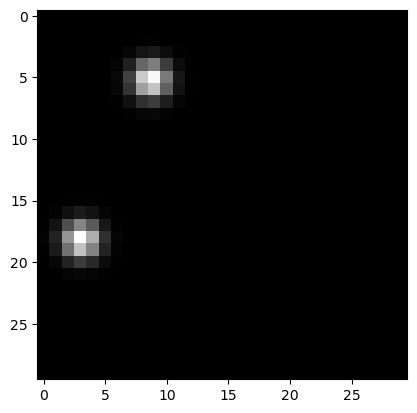

In [32]:
ex = np.array(df_judge1.iloc[-9,0:900])
ex = ex.astype('float64')
plt.imshow(ex.reshape((30,30)), cmap = 'gray')

Next we build the function which takes a row as a parameter, finds the location of the shower, assumes that the amplitude of shower is equal to 5 (mean value is 3,8, let's take a bit more) and masks this shower by changing the values of the pixels that consist the shower to zeros.

In [33]:
def find_and_mask_shower(row):
    rows = 30
    columns = 30
    
    arr = np.array(row[0:900])
    
    #reshape the array to get a 2-D array
    square = arr.reshape(30, 30)
    
    #find the coordinates of the brightest pixel
    coord_X, coord_Y = unravel_index(square.argmax(), square.shape)

    #assume the amplitude equals 5
    amp =  5
    
    #find the upper left corner of the area where the shower is located
    start_X = coord_X - amp/2
    start_Y = coord_Y - amp/2

    #find lower right corner of the area which consists the shower
    end_X = start_X + amp
    end_Y = start_Y + amp

    #then set the pixels between the start and end corners to zeros
    for r in range(rows):
        for c in range(columns):
            if (r >= start_X) and (r <= end_X) and (c >= start_Y) and (c <= end_Y):
                square[r,c] = 0 


    fl = square.flatten()
    #create Series of the 900 new values and return it
    s = pd.Series(fl, copy=False)
    
    return s

Apply the function to the testing dataframe

In [35]:
df_judge1.iloc[:,0:900] = df_judge1.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge1

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   

       49   50   51   52   53   54   55   56   57   58   59   60   61   62  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

And show the picture

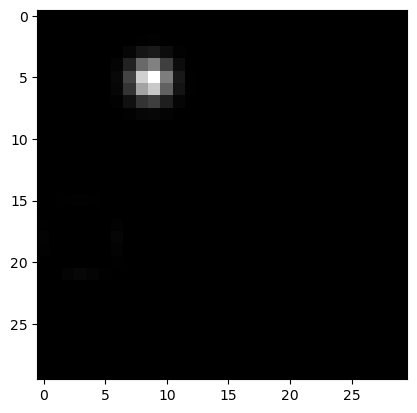

In [36]:
plt.imshow(np.array(df_judge1.iloc[-9:-8,0:900]).reshape((30,30)), cmap = 'gray')

As we see, the second shower is disappeared

Now we can create a copy of the entire dataframe and apply the function that masks the shower to it

In [37]:
df_judge_1_shower_masked = df_judge.copy()
df_judge_1_shower_masked.iloc[:,0:900] = df_judge_1_shower_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_1_shower_masked.tail(12)

0    1    2    3    4    5    6    7       8       9      10      11  \
1988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1988  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1989  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1989  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1988  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1989  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  

Now when the one of the showers is masked, let's try to use our model again on the base of the new data to find the amplitude, coordinate X and Y of the second shower, and add this information to our dataframe

In [41]:
df_X = df_judge_1_shower_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_1_shower = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_1_shower_masked['amplitude2'] = preds_judge_minus_1_shower[:,0].flatten()
df_judge_1_shower_masked['X2'] = preds_judge_minus_1_shower[:,1].flatten()
df_judge_1_shower_masked['Y2'] = preds_judge_minus_1_shower[:,2].flatten()
df_judge_1_shower_masked.tail(10)

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   

       49   50   51   52   53   54   55   56   57   58   59   60   61   62  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

As we see from the dataframe, the model has found the amplitude and coordinates for each row. For these rows where there is only one shower, the amplitude of the second showers is really small. Probably, the model has considered as shower just the leftovers of the not well masked the first shower. But it is not an issue, we just need to set the amplitude and the coordinates of the second shower to -1 value in the case of the only one shower. If we look at the rows where there are 2 and 3 showers, we see that the amplitude and the cooridates of the first and the second showers are not the same, what is good. That gives us hope, that the model works.

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have exactly one shower

In [49]:
df_judge_1_shower_masked['amplitude2'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='1' else x['amplitude2'], axis = 1)
df_judge_1_shower_masked['X2'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='1' else x['X2'], axis = 1)
df_judge_1_shower_masked['Y2'] = df_judge_1_shower_masked.apply(lambda x: -1 if x['number_of_showers']=='1' else x['Y2'], axis = 1)
df_judge_1_shower_masked

0    1    2       3       4       5       6       7       8       9  \
0     0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1     0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2     0.0  0.0  0.0  0.0003  0.0007  0.0008  0.0003  0.0001  0.0000  0.0000   
3     0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4     0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
...   ...  ...  ...     ...     ...     ...     ...     ...     ...     ...   
1995  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0002  0.0016   
1996  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

          10      11      12      13      14   15   16   17      18      19  \
0     0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0002   
1     0.0000  0.0006  0.0128  0.0000  0.0000  0.0  0.0  0.0  0.0063  0.0002   
2     0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
3     0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
4     0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
...      ...     ...     ...     ...     ...  ...  ...  ...     ...     ...   
1995  0.0061  0.0091  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0000  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   
1999  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000   

          20      21      22      23      24      25      26      27      28  \
0     0.0095  0.1435  0.8491  1.9892  1.8558  0.6891  0.1011  0.0058  0.0001   
1     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
3     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1995  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1996  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1997  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

       29   30      31     32      33      34      35      36      37      38  \
0     0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1     0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
2     0.0  0.0  0.0001  0.001  0.0066  0.0175  0.0183  0.0076  0.0013  0.0001   
3     0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
4     0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
...   ...  ...     ...    ...     ...     ...     ...     ...     ...     ...   
1995  0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0001  0.0022   
1996  0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   

       39   40      41      42   43      44      45      46      47      48  \
0     0.0  0.0  0.0000  0.0000  0.0  0.0001  0.0004  0.0008  0.0007  0.0003   
1     0.0  0.0  0.

Next let's apply our function that masks a shower to those of rows which have 3 showers

In [50]:
df_judge_2_showers_masked = df_judge_1_shower_masked.copy()
df_judge_2_showers_masked.iloc[:,0:900] = df_judge_2_showers_masked.apply(lambda x: find_and_mask_shower(x), axis = 1)
df_judge_2_showers_masked.tail(10)

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   

       49   50   51   52   53   54   55   56   57   58   59   60   61   62  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Let's use our model again on the base of the new data to find the amplitude, coordinate X and Y of the third shower

In [51]:
df_X = df_judge_2_showers_masked.iloc[:,0:900]

#Predict the new outputs 
preds_judge_minus_2_showers = model1.predict(df_X)

#Add the new predictions to the dataframe
df_judge_2_showers_masked['amplitude3'] = preds_judge_minus_2_showers[:,0].flatten()
df_judge_2_showers_masked['X3'] = preds_judge_minus_2_showers[:,1].flatten()
df_judge_2_showers_masked['Y3'] = preds_judge_minus_2_showers[:,2].flatten()
df_judge_2_showers_masked.tail(10)

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   

       49   50   51   52   53   54   55   56   57   58   59   60   61   62  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Set the amplitude, coordinate X and Y values equal to -1 for the rows which have one or two showers

In [53]:
df_judge_2_showers_masked['amplitude3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers']!='3' else x['amplitude3'], axis = 1)
df_judge_2_showers_masked['X3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers']!='3' else x['X3'], axis = 1)
df_judge_2_showers_masked['Y3'] = df_judge_2_showers_masked.apply(lambda x: -1 if x['number_of_showers']!='3' else x['Y3'], axis = 1)
df_judge_2_showers_masked.tail(10)

0    1    2    3    4    5    6    7       8       9      10      11  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0002  0.0016  0.0061  0.0091   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  0.0000  0.0000  0.0000   

          12      13      14   15   16   17   18   19   20   21   22   23  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0055  0.0013  0.0001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       24   25   26   27   28   29   30   31   32   33   34   35   36      37  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0001   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000   

          38      39      40   41   42   43      44      45   46   47   48  \
1990  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1991  0.0003  0.0003  0.0002  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1992  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1993  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1994  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1995  0.0022  0.0000  0.0000  0.0  0.0  0.0  0.0016  0.0001  0.0  0.0  0.0   
1996  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1997  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1998  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   
1999  0.0000  0.0000  0.0000  0.0  0.0  0.0  0.0000  0.0000  0.0  0.0  0.0   

       49   50   51   52   53   54   55   56   57   58   59   60   61   62  \
1990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1993  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Now let's save the results to csv-file and hope that they are correct

In [55]:
output_judge = df_judge_2_showers_masked[['amplitude', 'X', 'Y', 'amplitude2', 'X2', 'Y2', 'amplitude3', 'X3', 'Y3']]
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem4"
output_judge.to_csv(os.path.join(path,"output_judge.csv"),index=False,header=False)